In [1]:
# referenced from https://qiita.com/takubb/items/7d45ae701390912c7629
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

from PIL import Image

# from tqdm import tqdm  #コマンドラインで実行するとき
from tqdm.notebook import tqdm  # jupyter で実行するとき
from models import RESNETLIKE, MyModel, MyModel_shallow

In [2]:
# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# データセットの作成
trans = transforms.Compose([
    transforms.ToTensor()
])

class FocusPatchDataset(torch.utils.data.Dataset):
    # FILEはデータが入っていたファイル、imsize = 画像サイズ、psize = パッチサイズ
    def __init__(self, DIR, imsize, psize, channels, DEPTH_GAP, n_sample, transforms):
        
        # ground truth depthを読み込む

        with open(os.path.join(DIR,'depth.pkl'),"rb") as f:
            self.gt = pickle.load(f)

        if self.gt is None:
            print('cannot find ', os.path.join(DIR,'depth.pkl'))
            return None
        
        self.files = glob.glob(os.path.join(DIR,'[0-9]*.bmp'))
        print(self.files)
        self.fvalues = []
        for fn in self.files:
            self.fvalues.append(int(os.path.splitext(os.path.basename(fn))[0]))
        self.fvalues.sort()
        
        self.DIR = DIR
        self.DEPTH_GAP = DEPTH_GAP
        self.psize = psize
        self.channels = channels
        self.transforms = transforms
        self.n_sample = n_sample

        self.imsize = imsize
        self.psize = psize
        self.locs = []

        # サンプル対象となる点を設定する
        w = imsize[0]
        h = imsize[1]        
        for i in range(self.n_sample):
            xx = random.randint(0,w-self.psize)
            yy = random.randint(0,h-self.psize)
            self.locs.append([xx,yy])

        print('locations', self.locs)
    
    def __len__(self):
        length = (len(self.fvalues) - self.DEPTH_GAP)*self.n_sample
        return length

    def __getitem__(self, index):
        imgs = []

        # n: file (data) index, m: point index
        n = index // self.n_sample
        m = index % self.n_sample

        # val = self.fvalues[n]

        x = self.locs[m][0]
        y = self.locs[m][1]

        print(self.gt[y,x])
        
        val = float(self.gt[y,x]) - float(self.fvalues[n])

        FILE1 = os.path.join(self.DIR,f'{self.fvalues[n]:04d}.bmp')
        FILE2 = os.path.join(self.DIR,f'{self.fvalues[n+self.DEPTH_GAP]:04d}.bmp')

        print(val,FILE1,FILE2,x,y)
        
        img = Image.open(FILE1)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)

        img = Image.open(FILE2)
        img = img.crop((x, y, x+self.psize, y+self.psize))
        img = img.convert('L')
        img = np.array(img)
        img = np.array(img).astype('float32')
        imgs.append(img)
        
        out = np.stack(imgs,axis=2)
        #print(out.shape)
        
        return self.transforms(out), val

In [4]:
PSIZE = 65
DEPTH_GAP = 50
N_SAMPLE = 20
dataset = FocusPatchDataset(DIR = 'data/202410041747-new', imsize = [1600,1200], 
                            psize=PSIZE, channels=2, n_sample=N_SAMPLE, 
                            DEPTH_GAP=DEPTH_GAP, transforms = trans)

FileNotFoundError: [Errno 2] No such file or directory: 'data/202410041747-new\\depth.pickle'

In [47]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7,0.3])
len(dataset)

7020

In [48]:
# データローダーの作成
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=256,  # バッチサイズ
                                           shuffle=True,  # データシャッフル
                                           num_workers=0,  # 高速化
                                           pin_memory=True  # 高速化                                      
                                           )
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=256,
                                          shuffle=True,
                                          num_workers=0,  # 高速化
                                          pin_memory=True  # 高速化                                                   
                                          )

In [49]:
# モデル・損失関数・最適化アルゴリスムの設定
LOAD_WEIGHT = False
# model = RESNETLIKE(channels=2).to(device)
model = MyModel(channels=2)
#model = MyModel_shallow(channels=2).to(device)
weight_file = f"weight/weight_{PSIZE}_{DEPTH_GAP}.pth"

if LOAD_WEIGHT == True:
    # 学習済みモデルのロード
    model.load_state_dict(torch.load(weight_file))
    model.eval()

model = model.to(device)

criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters())
#optimizer = optim.SGD(model.parameters())

In [50]:
# モデル訓練関数
def train_model(model, train_loader, test_loader):
    # Train loop ----------------------------
    model.train()  # 学習モードをオン
    train_batch_loss = []
    for data, val in train_loader:
        # GPUへの転送
        data, val = data.to(device), val.to(device)
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(data)
        val = val.unsqueeze(1).to(torch.float32)
        # 3. 誤差計算
        loss = criterion(output, val)
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()
        # train_lossの取得
        train_batch_loss.append(loss.item())

    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    with torch.no_grad():  # 勾配を計算なし
        for data, val in test_loader:
            data, val = data.to(device), val.to(device)
            output = model(data)
            val = val.unsqueeze(1).to(torch.float32)
            loss = criterion(output, val)
            test_batch_loss.append(loss.item())

    return model, np.mean(train_batch_loss), np.mean(test_batch_loss)

In [51]:
# 訓練の実行
epoch = 50
train_loss = []
test_loss = []

for epoch in tqdm(range(epoch)):
    model, train_l, test_l = train_model(model,train_loader,test_loader)
    train_loss.append(train_l)
    test_loss.append(test_l)    
    # 10エポックごとにロスを表示
    #if epoch % 5 == 0:
    print(f"Train loss: {train_loss[-1]:.3f}, Test loss: {test_loss[-1]:.3f}")

# 学習状況（ロス）の確認
plt.plot(train_loss, label='train_loss')
plt.plot(test_loss, label='test_loss')
plt.legend()

  0%|          | 0/50 [00:00<?, ?it/s]

[255 255 255]


TypeError: only length-1 arrays can be converted to Python scalars

In [14]:
# 学習済みモデルの保存・ロード
path_saved_model = "./saved_model_Mymodel"
# モデルの保存
torch.save(model.state_dict(), path_saved_model)

In [34]:
# 学習済みモデルから予測結果と正解値を取得
def retrieve_result(model, dataloader):
    model.eval()
    preds = []
    labels = []
    # Retreive prediction and labels
    with torch.no_grad():
        for data, label in dataloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            # Collect data
            preds.append(output)
            labels.append(label)
    # Flatten
    preds = torch.cat(preds, axis=0)
    labels = torch.cat(labels, axis=0)
    # Returns as numpy (CPU環境の場合は不要)
    preds = preds.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    return preds, labels


# データを作って評価してみる
dataset = FocusPatchDataset("202409191257-data.csv", imsize = [1600,1200], psize=65, channels=2, n_sample=1, transforms = trans)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False)
preds, labels = retrieve_result(model, test_loader)

locations [[693, 882]]


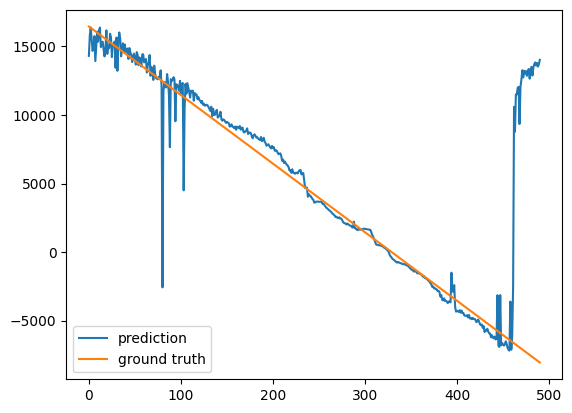

In [35]:
#for x,y in zip(preds,labels):
#    print(x,y,abs(x-y))
plt.plot(preds, label="prediction")
plt.plot(labels, label='ground truth')
plt.legend()